# Soft-sensor para predecir las concentraciones de producto en el proceso de cracking de etileno


## Carga de datos diarios de variables y concentraciones
#### Carga los datos del archivo "short_data.csv" en un Dataframe de pandas

In [0]:
import os
import utils as u

import utils as u
import pandas as pd


file_name = 'data/short_data.csv'
## lectura de csv

##renombrar columnas


## Selección de la variables independientes y variables objetivo
### Las variables objetivo son : 'H2_B', 'CH4_B', 'C2H4_B', 'C3H6_B'

#### Visualiza con matplotlib (seaborn, plotly) las variables objetivo


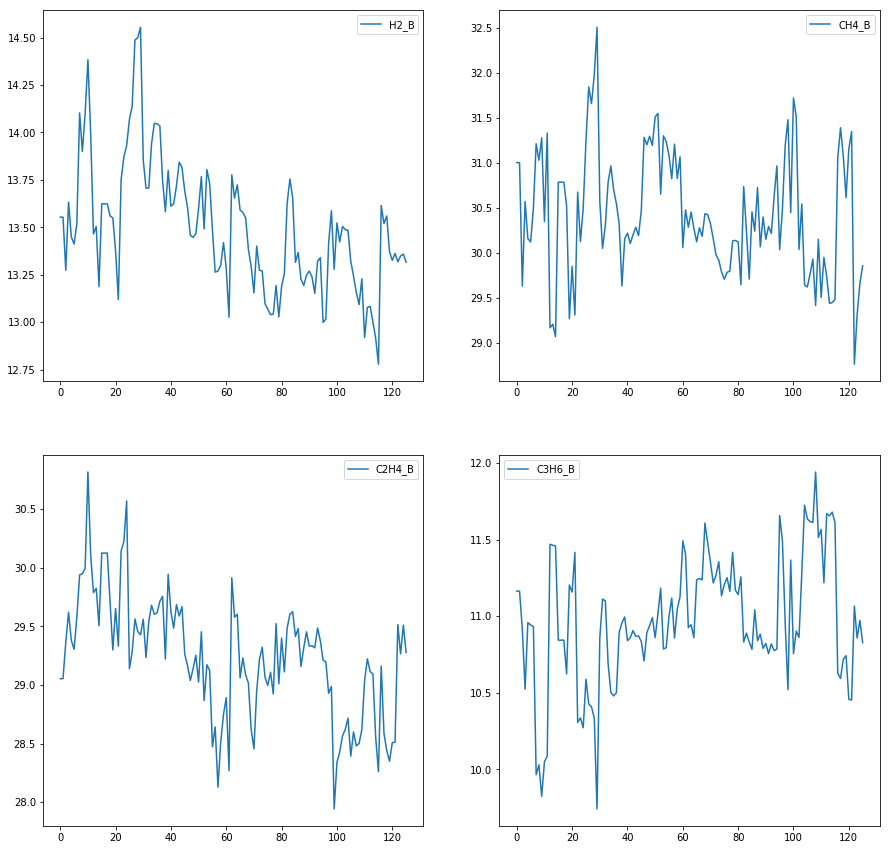

In [0]:
import matplotlib.pylab as plt
targets = ['H2_B', 'CH4_B', 'C2H4_B', 'C3H6_B']
#df['H2_B'].plot(figsize=(20,10),style='o--')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axs[0,0].plot(df['H2_B'].values,label='H2_B')
axs[0,0].legend()
axs[0,1].plot(df['CH4_B'].values,label='CH4_B')
axs[0,1].legend()
axs[1,0].plot(df['C2H4_B'].values,label='C2H4_B')
axs[1,0].legend()
axs[1,1].plot(df['C3H6_B'].values,label='C3H6_B')
axs[1,1].legend()
plt.show()

### Data cleaning
#### Prueba a limpiar los datos y visualiza el resultado

In [0]:
import numpy as np
window = 900
clean_data = df.copy()
for input in clean_data[u.all_labels].columns:
    clean_data = clean_data[clean_data.columns][np.invert(u.mad_based_outlier(clean_data[input],3))]

print (df.shape)
print (clean_data.shape)

(126, 42)
(105, 42)


### Visualizacióón de la limpieza de datos

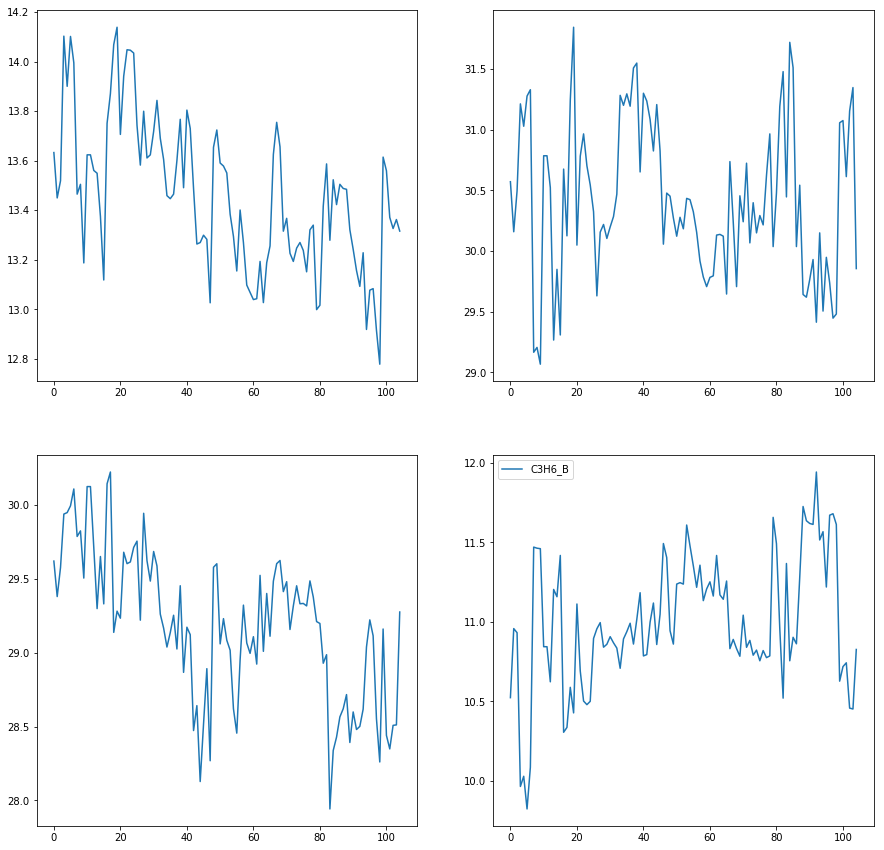

In [0]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axs[0,0].plot(clean_data['H2_B'].values,label='H2_B')
axs[0,1].plot(clean_data['CH4_B'].values,label='CH4_B')
axs[1,0].plot(clean_data['C2H4_B'].values,label='C2H4_B')
axs[1,1].plot(clean_data['C3H6_B'].values,label='C3H6_B')
plt.legend()
plt.show()

#### Selecciona las variables independientes y el target (es decir X e Y)

In [0]:
X = df[u.independent_labels]
Y_label = 'CH4_B'
Y = df[Y_label].values.ravel()
#Y = Y.reshape(len(Y))


## Particionado del conjunto de datos, se usa la regla habitual de 1/3
### La librería Pandas proporciona métdos de validación con este otro tipo Bootstrap
#### Particiona el conjunto de datos con la funcióón "train_test_split"

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, range(len(Y)),test_size=0.3, random_state=1)

## Instanciamos el modelo a usar, en este caso Gradient Boosting.
### Pandas proporciona este algoritmo de fácil uso. La parametrización se ha realizado con un método de búsqueda evolutiva

#### Hacer prueba con Gradient boosting, también se puede instanciar otro modelo de forma sencilla, por ejemplo random forest

In [0]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=750, learning_rate=0.1,max_depth=10, loss='quantile',alpha=0.4)

## Entrenamiento del modelo.
### Es interesante conocer la importancia de cada variable en la regresión
#### Entrenar el modelo e imprimir "feature_importance"

In [0]:
model.fit(X_train, y_train)
print ("Feature importances:"+str(model.feature_importances_))

Feature importances:[0.03065618 0.04326063 0.02749397 0.03145348 0.02798036 0.023906
 0.02249138 0.02662711 0.02149091 0.02067985 0.02072511 0.02317057
 0.02765802 0.02413401 0.0304178  0.01953298 0.01904972 0.02866353
 0.04127231 0.02923971 0.03322154 0.03079832 0.03459644 0.03930724
 0.0404677  0.02246497 0.0244982  0.0266768  0.04383355 0.03467064
 0.03624231 0.03682948 0.01602969 0.04045952]


## Evaluación del modelo.
### Extraer el Training error, RMSE y R2 score

In [0]:
from math import sqrt
from sklearn.metrics.regression import mean_squared_error, r2_score


predictions = model.predict(X_train)
nrmse = (sqrt(mean_squared_error(y_train,predictions)) / (max(y_train)-min(y_train)))
print ("RMSE Normalized: " +str(nrmse))
print ("R2 score, coefficient of determination: "+str(r2_score(y_train,predictions)))

RMSE Normalized: 0.0005274393356341551
R2 score, coefficient of determination: 0.9999923015497766
1-Correlation coefficient: 3.5258418260575297e-06


#### Visualización de la predicción en el entrenamiento

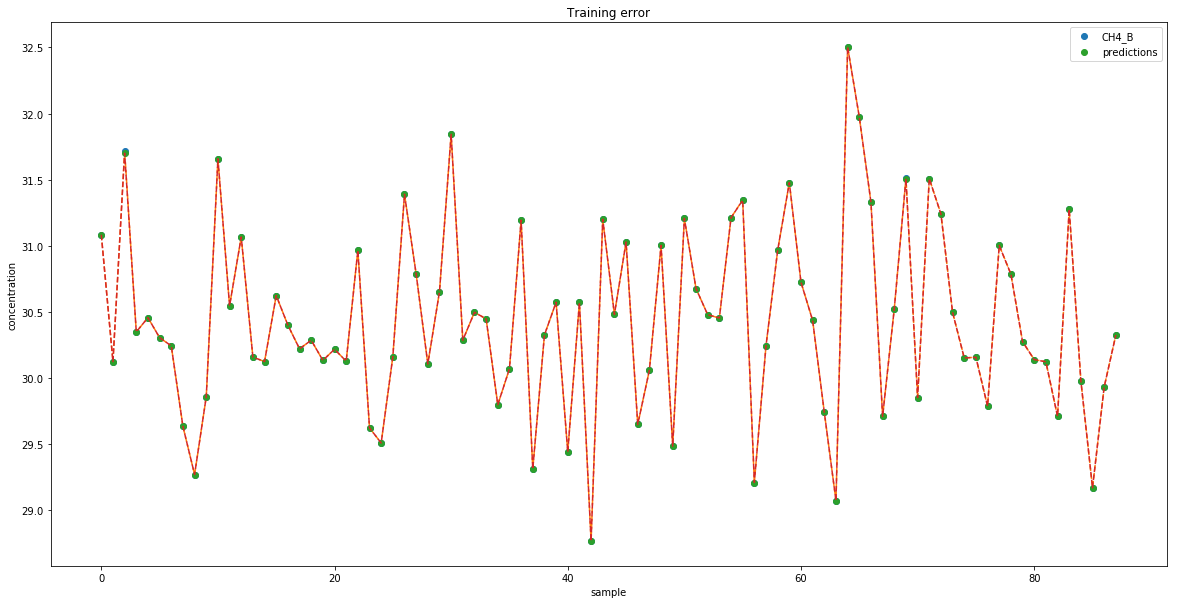

In [0]:
plt.figure("Training error",figsize=(20,10))
plt.plot(y_train,'o',label = Y_label)
plt.plot(y_train,'--')
plt.plot(predictions, 'o',label = 'predictions')
plt.plot(predictions, '--')
plt.title("Training error")
plt.xlabel("sample")
plt.ylabel("concentration")
plt.legend(loc='best')
plt.show()

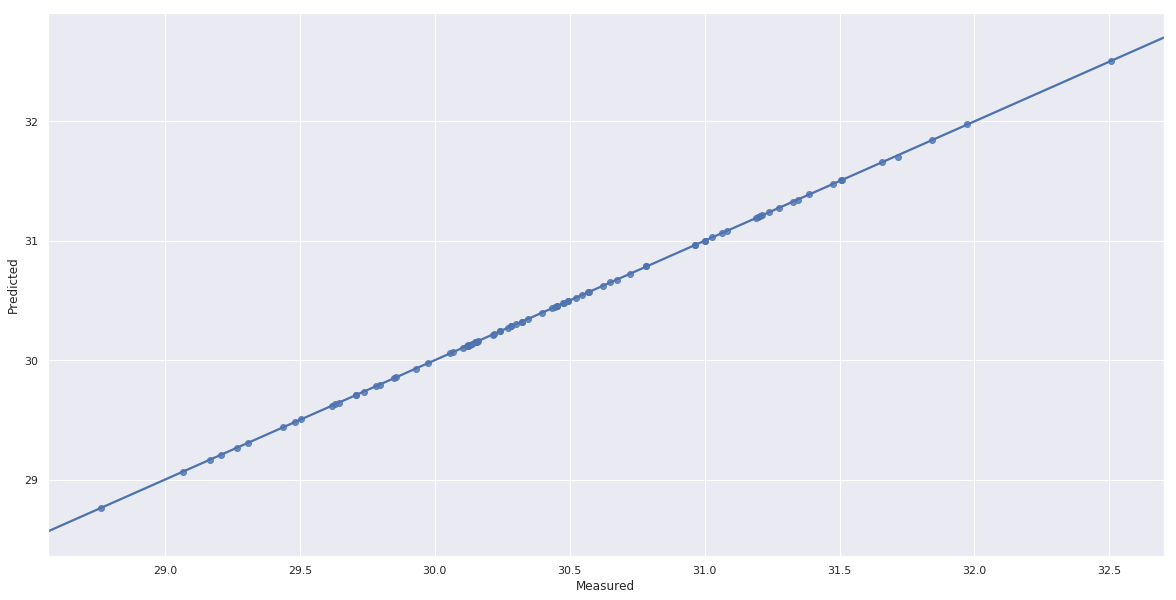

In [0]:
import seaborn as sns;
plt.figure("Training error",figsize=(20,10))
sns.set(color_codes=True)
data_plot = pd.DataFrame()
data_plot['Measured'] = y_train
data_plot['Predicted'] = predictions

ax = sns.regplot(x="Measured", y="Predicted", data=data_plot)
plt.show()

### Extrae el error de test RMSE y R2 score

In [0]:
predictions = model.predict(X_test)
nrmse = (sqrt(mean_squared_error(y_test,predictions)) / (max(y_test)-min(y_test)))
print ("\nTest error")
print ("RMSE Normalized: "+str(nrmse))
print ("R2 score, coefficient of determination: "+str(r2_score(y_test,predictions)))


Test error
RMSE Normalized: 0.14311230562741012
R2 score, coefficient of determination: 0.7214449322952794
1-Correlation coefficient: 0.14517990177176443


#### Visualización de la predicción de test

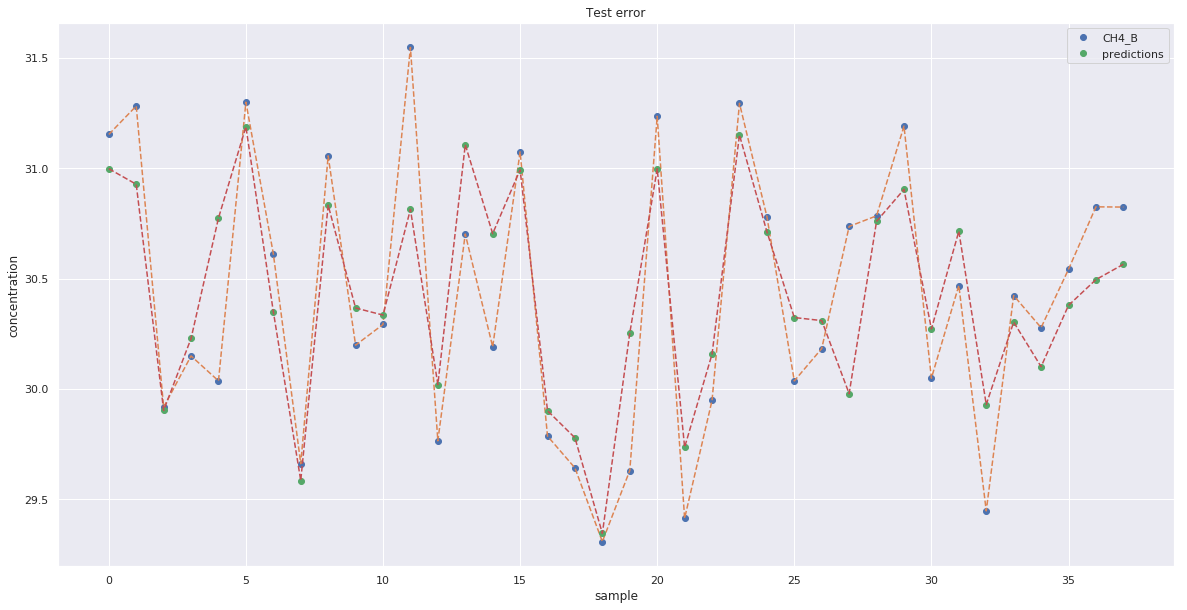

In [0]:
plt.figure("Test error", figsize=(20,10))
plt.plot(y_test,'o',label = Y_label,)
plt.plot(y_test,'--')
plt.plot(predictions, 'o',label = 'predictions')
plt.plot(predictions, '--')
plt.title("Test error")
plt.xlabel("sample")
plt.ylabel("concentration")
plt.legend(loc='best')
plt.show()

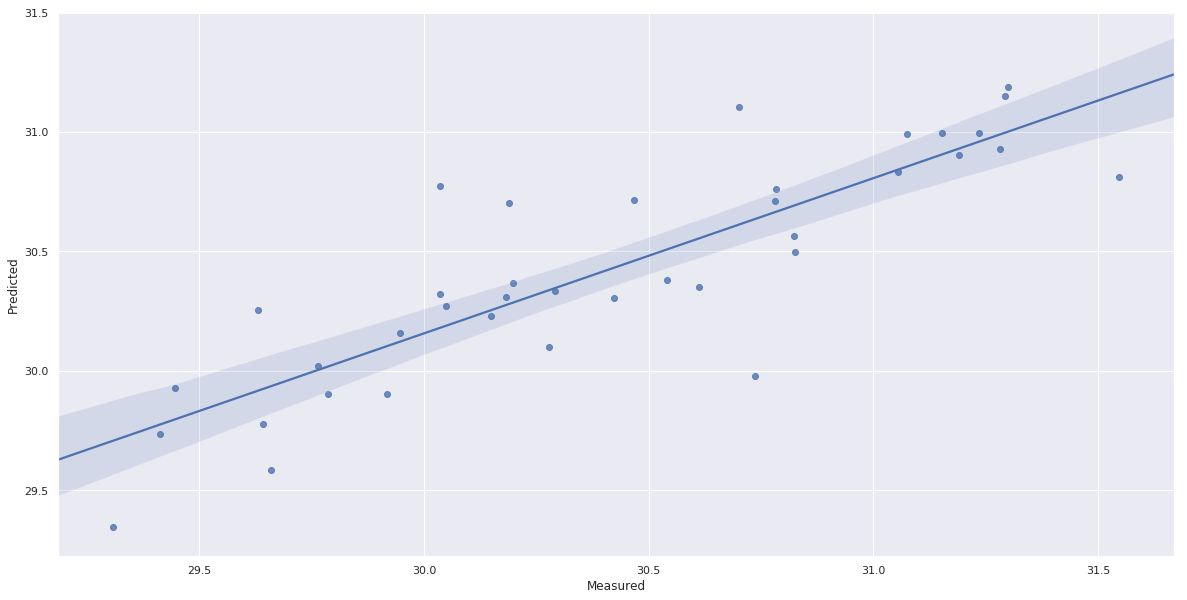

In [0]:
plt.figure("Test error",figsize=(20,10))
sns.set(color_codes=True)
data_plot = pd.DataFrame()
data_plot['Measured'] = y_test
data_plot['Predicted'] = predictions

ax = sns.regplot(x="Measured", y="Predicted", data=data_plot)
plt.show()